<a href="https://colab.research.google.com/github/Basu8971/Materraproject/blob/main/soilmoisture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-70-fa668b9a03f0>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_soil_data['DayOfYear'] = filtered_soil_data['Date'].dt.dayofyear


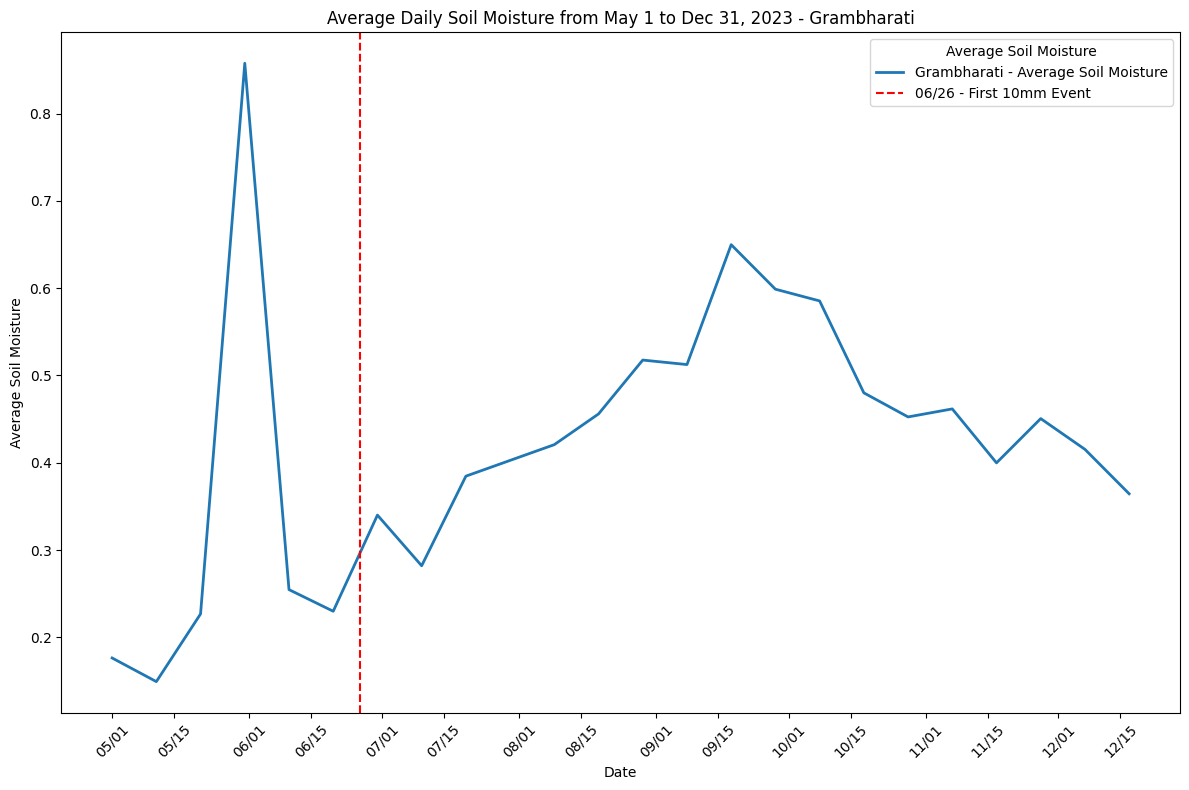

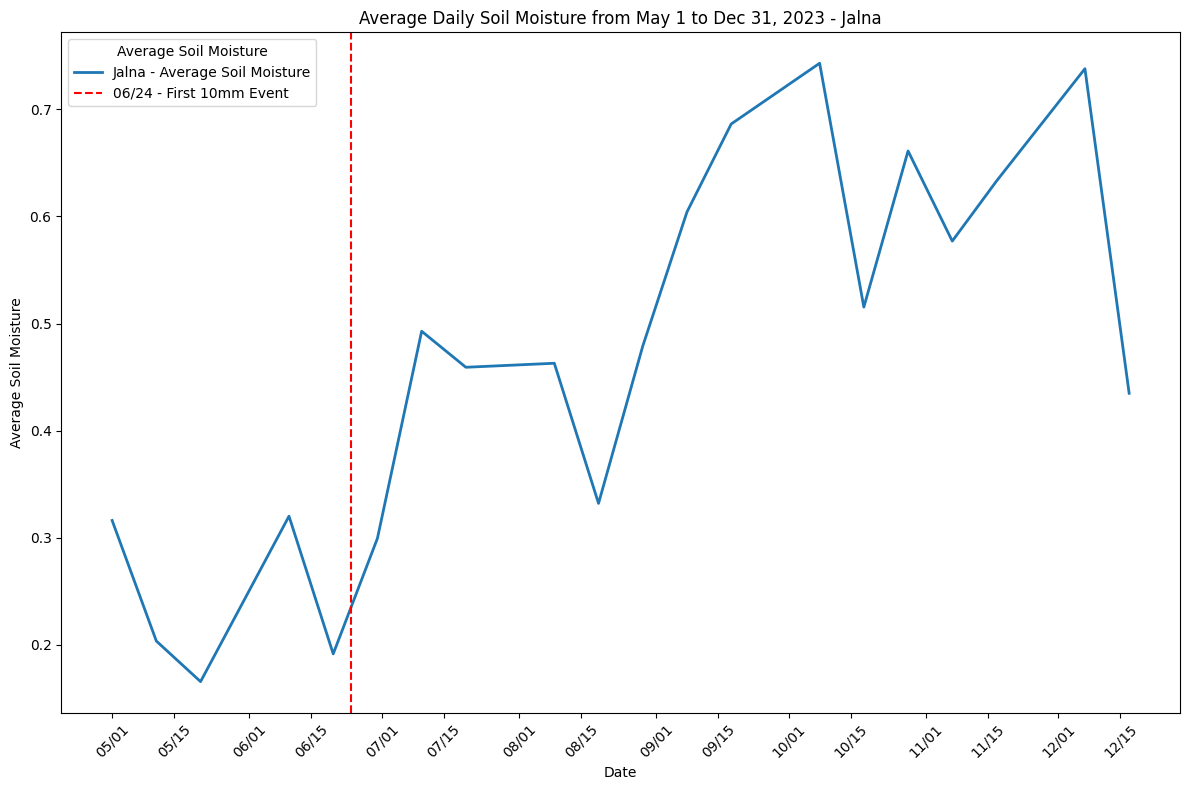

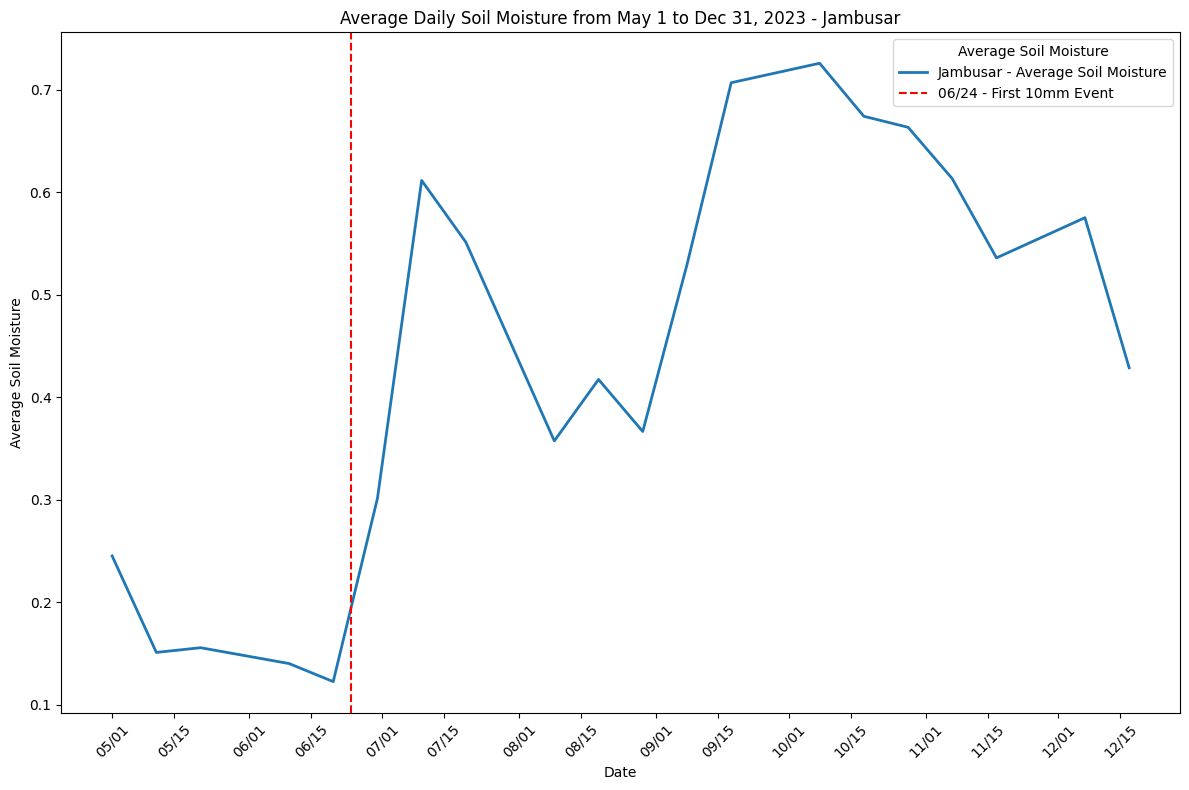

In [70]:
# Step 1: Install necessary libraries (if not already installed)
!pip install --upgrade gspread google-auth pandas matplotlib seaborn

# Step 2: Authenticate with Google using google-auth
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Authenticate the Google account
auth.authenticate_user()

# Use google-auth to get credentials and authorize gspread
creds, _ = default()
gc = gspread.authorize(creds)

# Step 3: Access Google Sheets using URLs
soil_moisture_sheet_url = 'https://docs.google.com/spreadsheets/d/1pDn2C9NthsvFSCnXoyOLD0Tx4G2y96bYbcom4H5lKhs/edit?gid=1431279503#gid=1431279503'

# Open the Google Sheet using gspread
soil_moisture_sheet = gc.open_by_url(soil_moisture_sheet_url)

# Load the data from the sheet into DataFrame
soil_moisture_data = pd.DataFrame(soil_moisture_sheet.sheet1.get_all_records())  # Soil Moisture data

# Step 4: Clean and process the data (strip extra spaces)
soil_moisture_data.columns = soil_moisture_data.columns.str.strip()

# Step 5: Convert 'Date' to datetime format
soil_moisture_data['Date'] = pd.to_datetime(soil_moisture_data['Date'], errors='coerce')

# Step 6: Filter data for the date range (May 1, 2023 to Dec 31, 2023)
filtered_soil_data = soil_moisture_data[(soil_moisture_data['Date'].dt.year == 2023) &
                                        (soil_moisture_data['Date'].dt.month >= 5) &
                                        (soil_moisture_data['Date'].dt.month <= 12)]

# Step 7: Extract Day of Year from 'Date' for plotting (DOY 1 to 365/366)
filtered_soil_data['DayOfYear'] = filtered_soil_data['Date'].dt.dayofyear

# Step 8: Group by Location and DayOfYear, and calculate the average soil moisture for each location across all years
location_groups = filtered_soil_data.groupby(['Location', 'DayOfYear'])['Soil_moisture'].mean().reset_index()

# Step 9: Convert DayOfYear to actual dates for plotting
location_groups['Date'] = pd.to_datetime('2023-01-01') + pd.to_timedelta(location_groups['DayOfYear'] - 1, unit='D')

# Step 10: Create separate plots for each location
locations = location_groups['Location'].unique()

# Dates for marking vertical lines
mark_dates = {
    'Grambharati': '2023-06-26',
    'Jalna': '2023-06-24',
    'Jambusar': '2023-06-24'
}

for location in locations:
    # Filter data for each location
    location_data = location_groups[location_groups['Location'] == location]

    # Plot the average soil moisture for this location
    plt.figure(figsize=(12, 8))
    plt.plot(location_data['Date'], location_data['Soil_moisture'], label=f'{location} - Average Soil Moisture', linewidth=2)

    # Add vertical lines for the specified dates
    if location in mark_dates:
        mark_date = pd.to_datetime(mark_dates[location])  # Convert string to datetime
        plt.axvline(x=mark_date, color='r', linestyle='--', label=f'{mark_date.strftime("%m/%d")} - First 10mm Event')

    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('Average Soil Moisture')
    plt.title(f'Average Daily Soil Moisture from May 1 to Dec 31, 2023 - {location}')

    # Format the x-axis to display only Month/Day (e.g., 05/01, 05/16)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

    # Set x-axis limits and date intervals (e.g., every 15 days)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=(1, 15)))

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add a legend
    plt.legend(title='Average Soil Moisture')

    # Display the plot
    plt.tight_layout()
    plt.show()
